# Prepare and Analyze Time Series - Milestone 1

This Jupyter notebook serves as a solution to Milestone 1 of the liveProject on End-to-end Time Series Forecasting with Deep Learning.

Our aim in this Milestone is to perform preliminary data processing and cleaning to have preprocessed data ready, as shown by the red dotted box in the diagram below.

![Milestone 1](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/project1_milestone_1.png)

## Importing Necessary Libraries and Functions

Let us first import the necessary libraries and load the data that we will be working with throughout this Milestone.  

The data (data/sales.csv) that we are using is a daily retail sales dataset modified from the [M5 competition data](https://www.kaggle.com/c/m5-forecasting-accuracy/data). 

In this liveProject, you are a data scientist at a large retailer and your challenge is to forecast the sales of the respective stores by each category for the next 28 days.

Instruction:<br>
We have written the code to import the libraries so you can just run it. If you need other libraries while working on this notebook, please feel free to add the library to this cell below.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

%matplotlib inline

# suppress pandas SettingWithCopyWarning 
pd.options.mode.chained_assignment = None

## Previewing the Sales Data

Let us first have a preview of the data to understand what we will be working with.

Instruction:<br>
Read in the data *sales.csv* from the data folder into a pandas dataframe and preview the first 5 rows.

Note:<br>
If you are running this notebook in Colab, please upload *sales.csv* from the data folder.

In [2]:
sales_df = pd.read_csv('/home/kartheekraj/Timeseries/Deep_learning/Time_Series_Prep/DL_Prep/sales.csv')  # use this if running notebook in local 
sales_df.info()
sales_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      58230 non-null  object 
 1   store_id  58230 non-null  object 
 2   cat_id    58230 non-null  object 
 3   sales     58230 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.8+ MB


,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
1,2011-01-30,TX_1,FOODS,3844.97
2,2011-01-31,TX_1,FOODS,2888.03
3,2011-02-01,TX_1,FOODS,3631.28
4,2011-02-02,TX_1,FOODS,3072.18


As seen from the data preview above, there are 4 columns with ~58k rows. The daily sales (column: `sales`) for each store (column: `store_id`) and category (column: `cat_id`) are listed in each row.

If we generate the unique value count of the `store_id` and `cat_id`, we will see that there are 10 stores and 3 categories.

Instruction:<br>
Verify the number of unique values of `store_id` and `cat_id` each.

In [3]:
# unique count of store_id and cat_id
print(f"There are {sales_df.store_id.nunique()} stores and {sales_df.cat_id.nunique()} categories.")

There are 10 stores and 3 categories.


And in terms of the time period, our sales data start from 2011 to 2016. We also set the `date` column to datetime format.

Instructions:<br>
Verify the date range of the `sales` data

In [4]:
# max and min date
sales_df['date'] = pd.to_datetime(sales_df.date)
print(f"Sales start from {sales_df.date.min()} to {sales_df.date.max()}")

Sales start from 2011-01-29 00:00:00 to 2016-05-22 00:00:00


## Processing of Data

There are 3 common data quality issues to check for time series data:
1. Irregular time series
2. Outliers
3. Missing data

### Data quality issue - Irregular time series

In our case, our sales data is of daily frequency. However, the data may possibly miss out some dates (see point 1 in image below) or added more rows for the same date (see point 2 in image below). Hence, we need to ensure that every date is accounted by exactly one row. 

For the scenario of point 2 in image below, we will also need to check with the data owner on the proper treatment, i.e., do we add up the sales of both rows to get sales for 2011-02-19 or do we just keep the row with time 00:00:00 because the data is a snapshot of sales? 



![Irregular Time Series](https://s3.ap-southeast-1.amazonaws.com/www.jiahao.io/manning/irregular_time_period.PNG)

Instruction:<br>
Check for duplicated dates within a store and category group

In [5]:
# if our date column is datetime, then we need to extract the date component and 
# check for duplicate dates within a store and category group
sales_df['date_part'] = sales_df['date'].dt.date
sales_df[sales_df.duplicated(['date_part', 'store_id', 'cat_id'])]
sales_df.drop(columns='date_part', inplace=True)

Good, there is no duplicated date in a store and category group.

Next let's try to see if there is missing date in between the start and end date of sales.

Instructions:<br>
Generate dataframe with the daily dates in between the start and end dates of sales. Then check if there is any missing date(s) in between.

In [6]:
# generate daily dates between the start and end of sales
total_days = (sales_df.date.max() - sales_df.date.min()).days + 1
dates_df = pd.DataFrame(pd.date_range(sales_df.date.min(), periods=total_days, freq="D"), columns=['date'])
display(dates_df.head(3))
display(dates_df.tail(3))

,date
0,2011-01-29
1,2011-01-30
2,2011-01-31


,date
1938,2016-05-20
1939,2016-05-21
1940,2016-05-22


In [7]:
# merge the dates dataframe with sales dataframe to check for missing dates
# in our case, lucky for us that there is no irregular time series data
sales_daily_df = dates_df.merge(sales_df, on='date', how='left')
sales_daily_df.info()
sales_daily_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58230 entries, 0 to 58229
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      58230 non-null  datetime64[ns]
 1   store_id  58230 non-null  object        
 2   cat_id    58230 non-null  object        
 3   sales     58230 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.2+ MB


,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
1,2011-01-29,TX_1,HOBBIES,759.99
2,2011-01-29,TX_1,HOUSEHOLD,1876.34
3,2011-01-29,TX_2,FOODS,5877.90
4,2011-01-29,TX_2,HOBBIES,1294.04


In [8]:
sales_daily_df.loc[(sales_daily_df.store_id=='TX_1') & (sales_daily_df.cat_id=='FOODS'), :]

,date,store_id,cat_id,sales
0,2011-01-29,TX_1,FOODS,3950.35
30,2011-01-30,TX_1,FOODS,3844.97
60,2011-01-31,TX_1,FOODS,2888.03
90,2011-02-01,TX_1,FOODS,3631.28
120,2011-02-02,TX_1,FOODS,3072.18
...,...,...,...,...
58080,2016-05-18,TX_1,FOODS,5146.18
58110,2016-05-19,TX_1,FOODS,4647.91
58140,2016-05-20,TX_1,FOODS,5977.50
58170,2016-05-21,TX_1,FOODS,6776.10


Luckily for us, there is no missing date in between. If there is any, the `sales` value will be null and we can impute them later.

### Data quality issue - Outliers

There are various ways to check for outliers in time series. Here, we use the Interquartile Range (IQR) method mentioned in the book [Forecasting: Principles and Practice](https://otexts.com/fpp3/missing-outliers.html) by Rob J Hyndman and George Athanasopoulos. However, we modified the method a little by detrending the time series first before applying the IQR method.

Instructions:<br>
- Code the IQR method and implement it on the sales data. Take care to check for outliers by each store and category group. The sales dataframe should have a column named `anomaly` that will indicate each outlier as True and non-outliers as False.
- Detrend the sales by each time series before applying the IQR method.

In [9]:
def outlier_detection(sales_series_df):
    """
    Add column 'anomaly' to dataframe to mark outliers as True, non-outliers as False. 
    """
    # calculate interquartile range
    Q1 = sales_series_df['sales_detrend'].quantile(0.25)
    Q3 = sales_series_df['sales_detrend'].quantile(0.75)
    IQR = Q3 - Q1

    # identify outliers
    # Filtering Values between Q1-3IQR and Q3+3IQR
    sales_series_df['anomaly'] = (sales_series_df.sales_detrend >= Q3 + 3*IQR) | (sales_series_df.sales_detrend <= Q1 - 3*IQR)
    
    return sales_series_df

outlier_marked_list = []

for store in sales_daily_df.store_id.unique():
    for category in sales_daily_df.cat_id.unique():
        sales_series_df = sales_daily_df.loc[(sales_daily_df.store_id==store) & (sales_daily_df.cat_id==category), :]
        # detrend sales for better detection of outliers
        sales_series_df['sales_detrend'] = signal.detrend(sales_series_df['sales'].values)
        sales_outlier_marked_df = outlier_detection(sales_series_df)
        outlier_marked_list.append(sales_outlier_marked_df)

outlier_marked_df = pd.concat(outlier_marked_list)

Let's take a look at how our outlier detection method performs.

In general, the method is able to capture most of the outliers (as seen from the diagrams below) that our human judgement would also determine to be outlying points. There are some outlying points that were missed out but we shall see in a while what these points may be and we can manually mark them as outlier if necessary.

We also noticed that some of the points towards the tail end of the time series for the store *CA_2* and category *FOODS* seem to be wrongly marked as outliers. We can unmark these points as well.

Instructions:<br>
Visualize the outliers identified by overlaying them on a sales line plot.

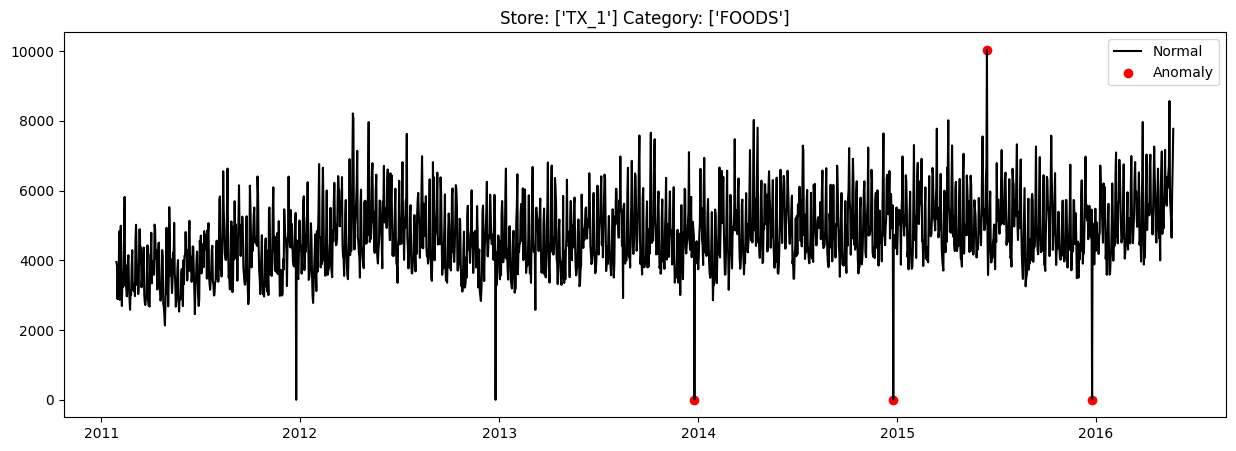

In [10]:
def visualize_outliers(store, category):
    outlier_series_df = outlier_marked_df.loc[(outlier_marked_df.store_id==store) & (outlier_marked_df.cat_id==category), :]
    # visualization of outliers detected
    fig, ax = plt.subplots(figsize=(15,5))
    a = outlier_series_df.loc[outlier_series_df['anomaly'] == 1, ['date', 'sales']] #anomaly
    ax.plot(outlier_series_df.date, outlier_series_df['sales'], color='black', label = 'Normal')
    ax.scatter(a.date, a['sales'], color='red', label = 'Anomaly')
    plt.title(f'Store: {outlier_series_df.store_id.unique()} Category: {outlier_series_df.cat_id.unique()}')
    plt.legend()
    plt.show()

# sample one of the store category to see how our outlier detection performs
visualize_outliers('TX_1', 'FOODS')

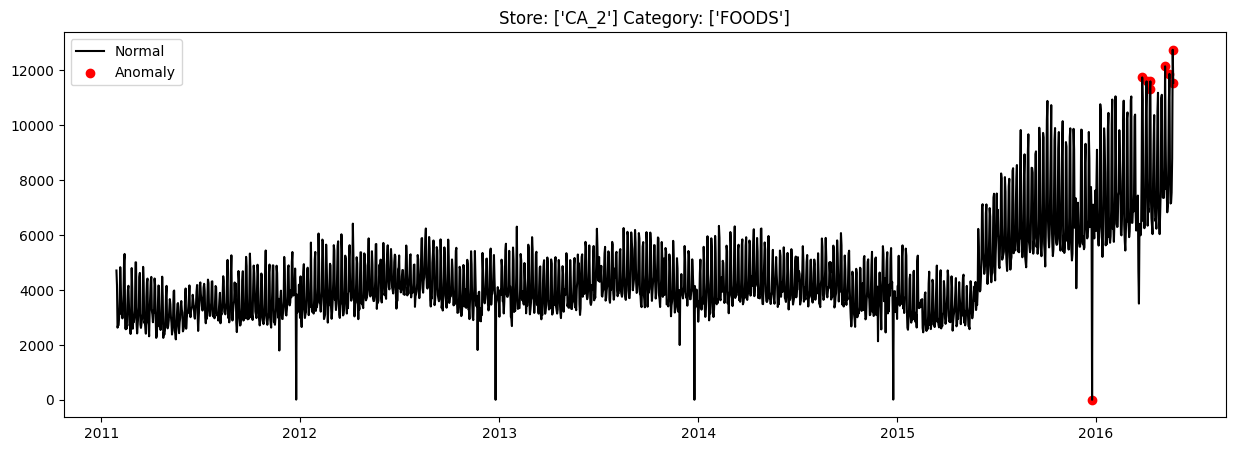

In [11]:
# sample one of the store category to see how our outlier detection performs
visualize_outliers('CA_2', 'FOODS')

We can unmark some of the points as outliers.

Instructions:<br>
If any of the "outliers" identified are incorrect, unmark them in your `anomaly` column.

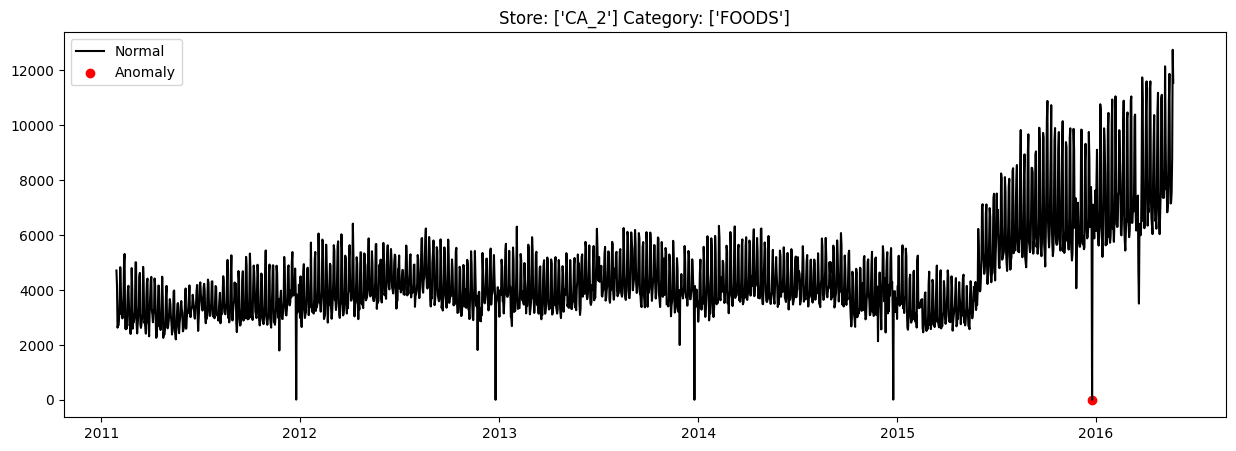

In [12]:
# unmark points as outliers
outlier_marked_df['anomaly'] = outlier_marked_df.apply(lambda x: False if x.store_id=='CA_2' and x.cat_id=='FOODS' and x.sales>10000 else x.anomaly, 1)

visualize_outliers('CA_2', 'FOODS')

It turns out that when we filter and zoom into those outlying points with sales very close to 0, they seem to generally occur on 25th Dec. Seems likely due to Christmas... Turns out when you spoke to the data owner, it was revealed that the stores close on Christmas hence the close to zero sales.

Let's mark these as outliers for the time being although we will need to take care to set predicted sales on Christmas to zero later.

Instructions:<br>
Mark any additional points as outliers if necessary in your `anomaly` column

In [13]:
outlier_marked_df.loc[outlier_marked_df.sales < 100]

,date,store_id,cat_id,sales,sales_detrend,anomaly
9900,2011-12-25,TX_1,FOODS,0.00,-4325.732392,False
20880,2012-12-25,TX_1,FOODS,0.00,-4564.055431,False
31830,2013-12-25,TX_1,FOODS,1.58,-4800.147315,True
42780,2014-12-25,TX_1,FOODS,0.00,-5039.399199,True
53730,2015-12-25,TX_1,FOODS,1.58,-5275.491082,True
...,...,...,...,...,...,...
9929,2011-12-25,WI_3,HOUSEHOLD,0.00,-2244.693915,False
20909,2012-12-25,WI_3,HOUSEHOLD,0.00,-2328.663615,False
31859,2013-12-25,WI_3,HOUSEHOLD,0.00,-2412.403890,False
42809,2014-12-25,WI_3,HOUSEHOLD,0.00,-2496.144164,False


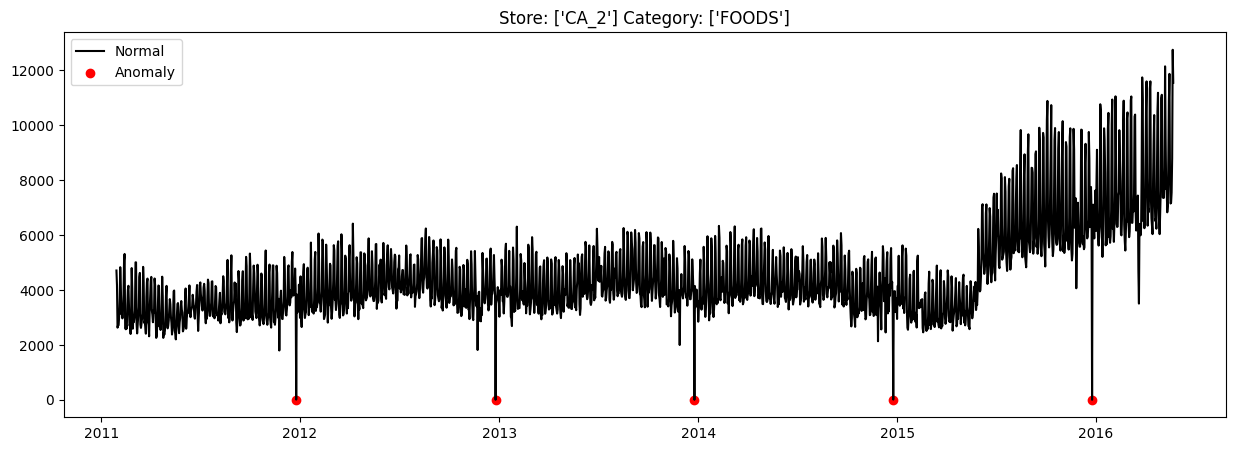

In [14]:
# mark points as outliers
outlier_marked_df['anomaly'] = outlier_marked_df.apply(lambda x: True if x.date.month==12 and x.date.day==25 else x.anomaly, 1)

visualize_outliers('CA_2', 'FOODS')

Finally, we will need to set our outliers to null sales value. In reality, we should talk to the data owner to find out the reasons for these outliers and decide if they are legitimate data points (e.g. the Christmas points) or erroneous points.

For the Christmas data points, they reflect the calendar effect and in some models, we can leave these data points as they are and add in covariates indicating these calendar effects into the model. However for us, we will be using univariate model and it would better for us to remove these calendar effects.

Before we set the outliers to null sales value, we can check for other null sales values if any and perform imputation in our next data quality check.

In [15]:
print(f"In total, we detected {outlier_marked_df.anomaly.sum()} outliers.")

In total, we detected 175 outliers.


### Data quality issue - Missing data

First let's check for missing sales value. Then we proceed to set outlier to null sales value as mentioned in previous data quality check. And finally perform imputation of sales.

Instructions:<br>
Check how many rows have missing sales value

In [16]:
# check number of rows with missing sales
sum(outlier_marked_df.sales.isna())

0

Good, seems like no missing sales. Well in fact, we knew there's no missing sales when we were previewing the data. But this is just for procedure.

Next we can set our outliers to null sales value.

Instructions:<br>
Set outliers to null sales value

In [17]:
outlier_marked_df.loc[outlier_marked_df['anomaly']==1, 'sales'] = np.nan

In [18]:
# check our missing sales data is equal to the number of outliers
sum(outlier_marked_df.sales.isna())

175

We can now proceed to impute the missing sales. In our case, we have no extended missing sales period and the number of data points with missing sales is little compared to the total number of data points. Hence, we shall adopt linear interpolation method.

First, we need to set the `date`, `store_id` and `cat_id` columns as index.

Instructions:<br>
Impute the missing sales using linear interpolation method.

Hint: [https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)

In [19]:
sales_imputed_df = outlier_marked_df.set_index(['store_id', 'cat_id', 'date'])
sales_imputed_df.interpolate(inplace=True)
sales_imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58230 entries, ('TX_1', 'FOODS', Timestamp('2011-01-29 00:00:00')) to ('WI_3', 'HOUSEHOLD', Timestamp('2016-05-22 00:00:00'))
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sales          58230 non-null  float64
 1   sales_detrend  58230 non-null  float64
 2   anomaly        58230 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 1.2+ MB


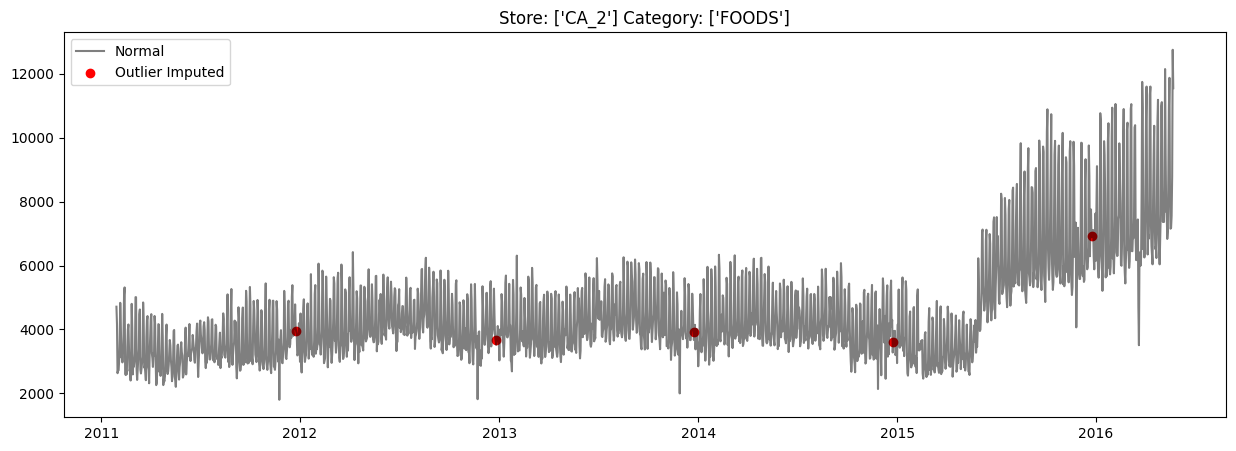

In [20]:
def visualize_sales(store, category):
    sales_series_df = sales_imputed_df.loc[(sales_imputed_df.index.get_level_values('store_id')==store) & (sales_imputed_df.index.get_level_values('cat_id')==category), :]
    sales_series_df.reset_index(inplace=True)
    # visualization of sales
    fig, ax = plt.subplots(figsize=(15,5))
    a = sales_series_df.loc[sales_series_df['anomaly'] == 1, ['date', 'sales']] #anomaly
    ax.plot(sales_series_df.date, sales_series_df['sales'], color='black', label = 'Normal', alpha=0.5)
    ax.scatter(a.date, a['sales'], color='red', label = 'Outlier Imputed')
    plt.title(f'Store: {sales_series_df.store_id.unique()} Category: {sales_series_df.cat_id.unique()}')
    plt.legend()
    plt.show()

# sample one of the store category to see how our outlier detection performs
visualize_sales('CA_2', 'FOODS')

With these data quality checks done, we have completed Milestone 1 and prepared our preprocessed data. Good job!

Now let's save our preprocessed data as `sales_processed.csv` in the data folder.

Instructions:<br>
Save the preprocessed data as `sales_processed.csv` in the data folder

In [21]:
sales_imputed_df.drop(columns=['sales_detrend', 'anomaly']).to_csv('/home/kartheekraj/Timeseries/Deep_learning/Time_Series_Prep/DL_Prep/sales_processed.csv')

In [22]:
sales_processed_df = pd.read_csv('/home/kartheekraj/Timeseries/Deep_learning/Time_Series_Prep/DL_Prep/sales_processed.csv')

In [23]:
sales_processed_df['date'] = pd.to_datetime(sales_processed_df.date)

In [24]:
sales_processed_df.head()

,store_id,cat_id,date,sales
0,TX_1,FOODS,2011-01-29,3950.35
1,TX_1,FOODS,2011-01-30,3844.97
2,TX_1,FOODS,2011-01-31,2888.03
3,TX_1,FOODS,2011-02-01,3631.28
4,TX_1,FOODS,2011-02-02,3072.18


In [25]:
sales_processed_df.cat_id.unique()

array(['FOODS', 'HOBBIES', 'HOUSEHOLD'], dtype=object)

In [26]:
sales_processed_df.store_id.unique()

array(['TX_1', 'TX_2', 'TX_3', 'CA_1', 'CA_2', 'CA_3', 'CA_4', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

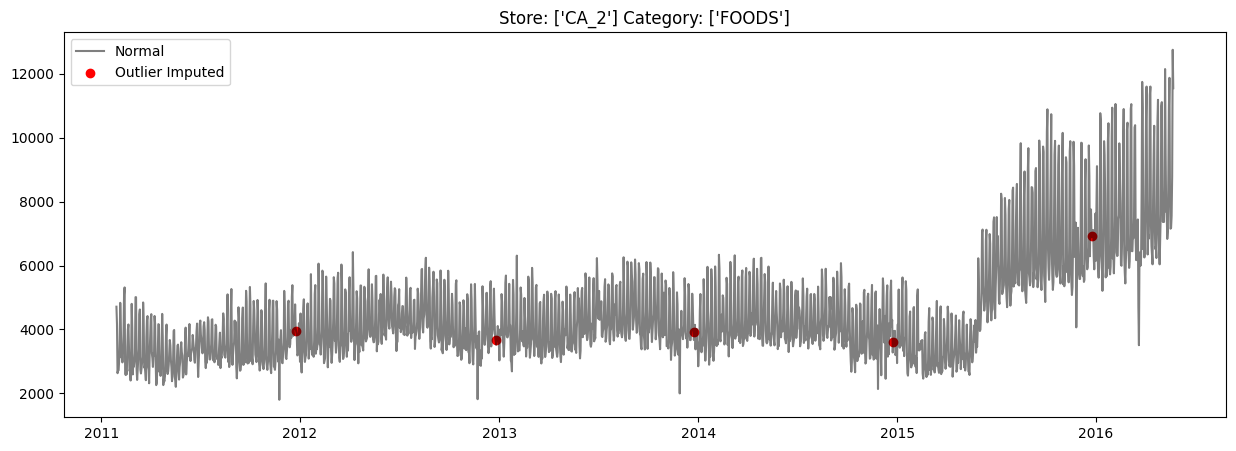

In [27]:
# sample one of the store category to see how our outlier detection performs
visualize_sales('CA_2', 'FOODS')

In [28]:
sp_df_copy=sales_processed_df.copy()

In [29]:
sales_processed_df.loc[(sales_processed_df.cat_id=='HOUSEHOLD'),:]

,store_id,cat_id,date,sales
3882,TX_1,HOUSEHOLD,2011-01-29,1876.34
3883,TX_1,HOUSEHOLD,2011-01-30,2064.04
3884,TX_1,HOUSEHOLD,2011-01-31,1262.27
3885,TX_1,HOUSEHOLD,2011-02-01,1263.71
3886,TX_1,HOUSEHOLD,2011-02-02,917.66
...,...,...,...,...
58225,WI_3,HOUSEHOLD,2016-05-18,2225.31
58226,WI_3,HOUSEHOLD,2016-05-19,2468.50
58227,WI_3,HOUSEHOLD,2016-05-20,3664.25
58228,WI_3,HOUSEHOLD,2016-05-21,3487.02


In [30]:
sp_df_copy.pivot_table(index='cat_id',columns='store_id',values='sales')

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
cat_id,,,,,,,,,,
FOODS,7037.351203,4541.681891,9554.494575,3817.328612,4752.848993,6261.587679,5335.410299,4388.846448,6040.377589,5656.987697
HOBBIES,1665.296497,1141.597643,1785.355201,988.063725,870.557589,1407.171082,1356.600299,1226.840304,747.957694,854.851255
HOUSEHOLD,3149.481095,3534.908228,5544.580129,1631.464804,2658.283846,3127.227772,2698.409232,2180.798694,2568.928833,2397.269879


<AxesSubplot:title={'center':'different stores sales in food categories'}, xlabel='date'>

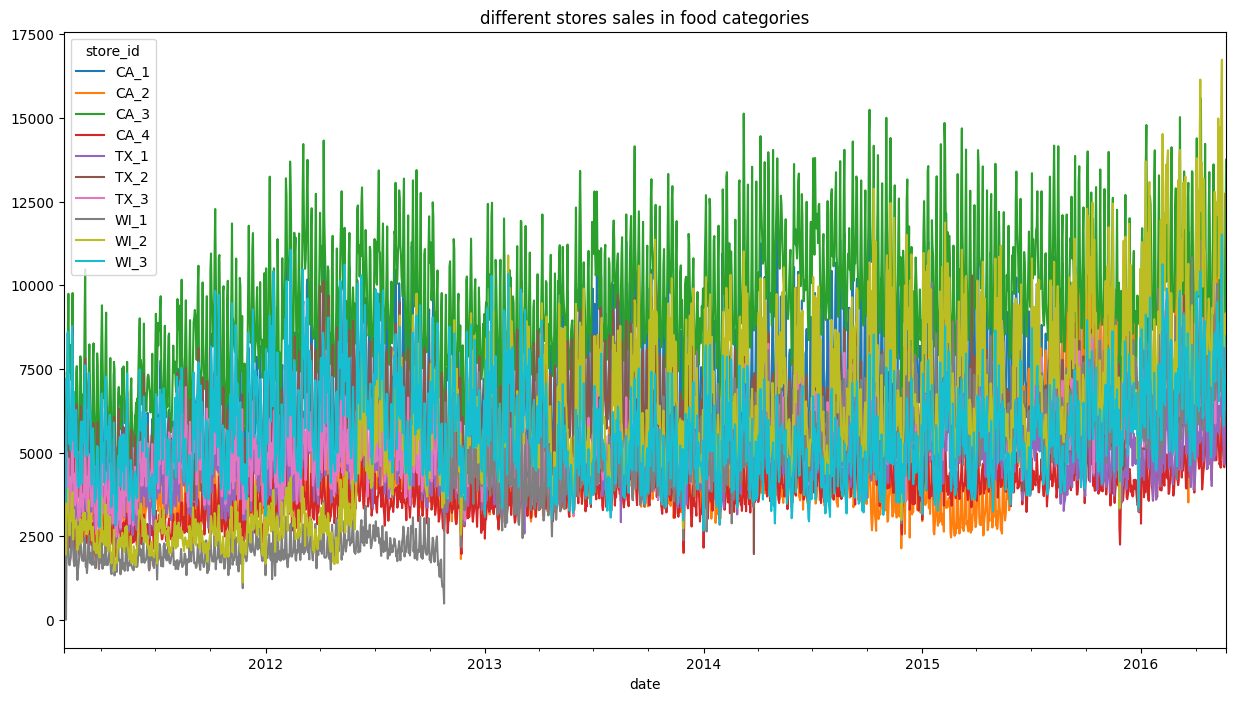

In [31]:
df_pivot=sp_df_copy.pivot_table(index='date',columns=['cat_id','store_id'],values='sales')
# df_pivot.plot(kind='line',figsize=(15,8))
df_pivot['FOODS'].plot(kind='line',title='different stores sales in food categories',figsize=(15,8))


<AxesSubplot:title={'center':'different stores sales in hobbies categories'}, xlabel='date'>

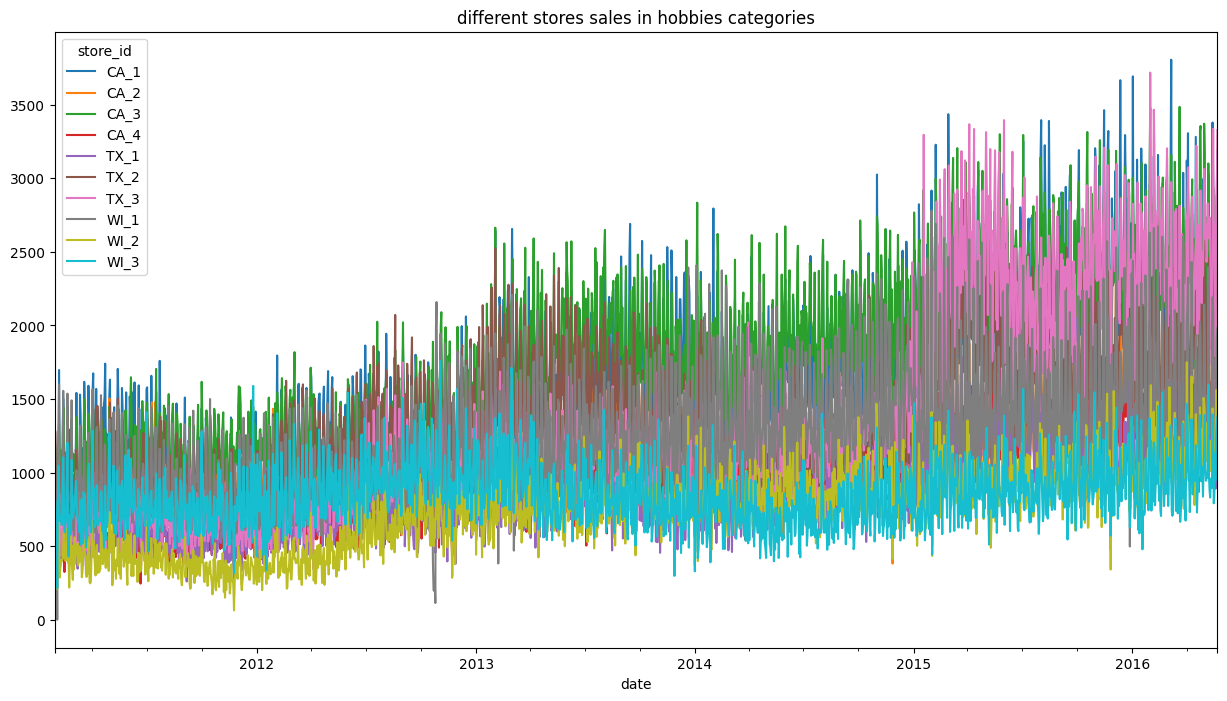

In [32]:
df_pivot['HOBBIES'].plot(kind='line',title='different stores sales in hobbies categories',figsize=(15,8))

<AxesSubplot:title={'center':'different stores sales in household categories'}, xlabel='date'>

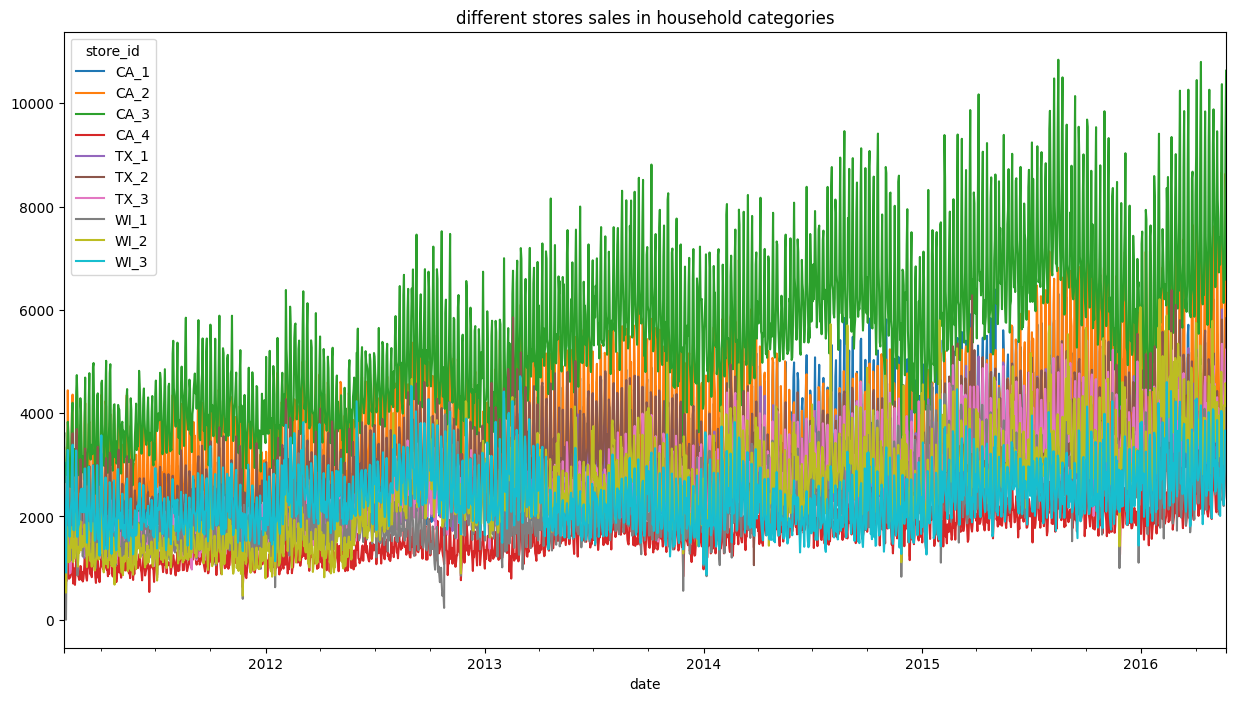

In [33]:
df_pivot['HOUSEHOLD'].plot(kind='line',title='different stores sales in household categories',figsize=(15,8))

<AxesSubplot:title={'center':'sales in different categories'}, xlabel='date'>

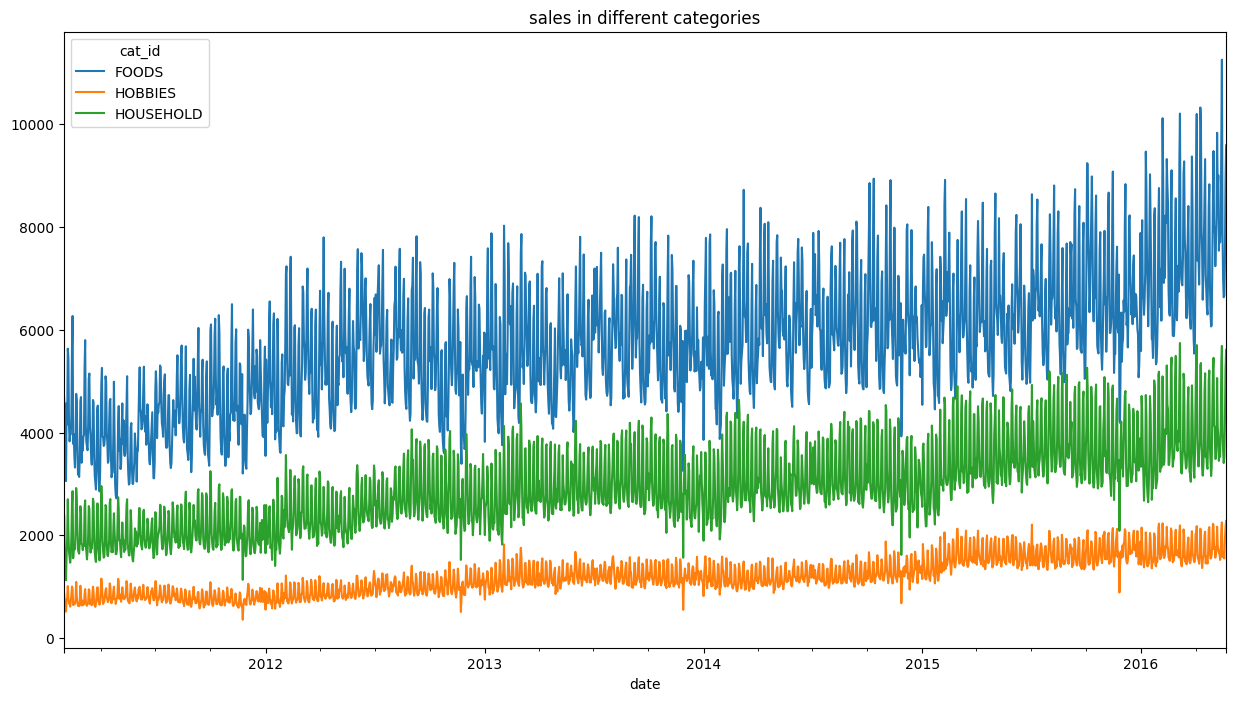

In [34]:
df_cat=sp_df_copy.pivot_table(index='date',columns='cat_id',values='sales')
df_cat.plot(kind='line',title='sales in different categories',figsize=(15,8))

<AxesSubplot:title={'center':'sales in different stores'}, xlabel='date'>

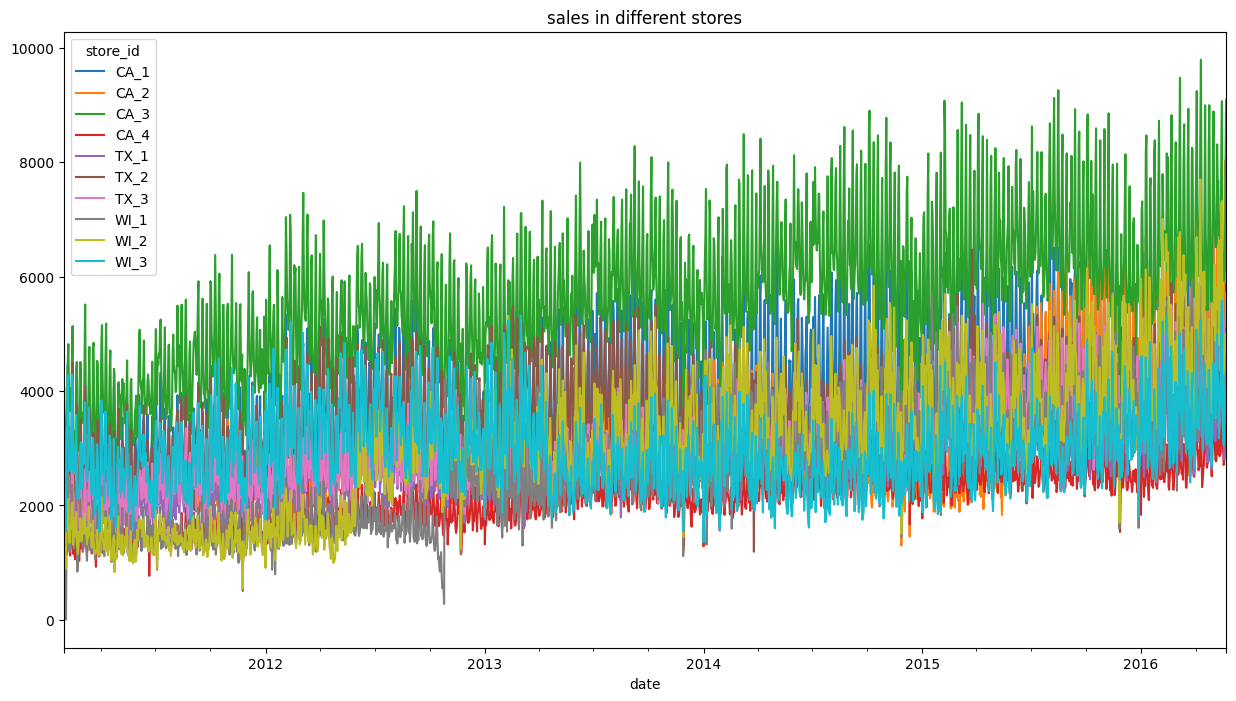

In [35]:
df_store=sp_df_copy.pivot_table(index='date',columns='store_id',values='sales')
df_store.plot(kind='line',title='sales in different stores',figsize=(15,8))

In [36]:
df_pivot_1=sp_df_copy.pivot_table(index='date',columns=['store_id','cat_id'],values='sales')
# df_pivot_1.plot(kind='line',figsize=(15,8))
df_pivot_1

store_id        CA_1                         CA_2                     \
cat_id         FOODS  HOBBIES HOUSEHOLD     FOODS  HOBBIES HOUSEHOLD   
date                                                                   
2011-01-29   7240.65  1369.91   2322.60   4712.14  1031.81   3357.57   
2011-01-30   6705.51   907.64   2173.91   4173.56   902.58   3341.39   
2011-01-31   4584.85   937.64   1678.89   2630.87   739.58   1950.06   
2011-02-01   4965.46   779.97   1662.31   2725.75   867.86   1956.95   
2011-02-02   4368.07   673.93   1524.12   2719.78   829.37   1680.57   
...              ...      ...       ...       ...      ...       ...   
2016-05-18   7566.39  1775.22   3579.01   7178.31  1458.19   4129.75   
2016-05-19   7480.58  2155.33   3623.99   7556.12  1495.21   4381.61   
2016-05-20   7846.33  2424.02   3729.30   8806.22  1760.52   4978.54   
2016-05-21  10309.37  2888.19   5440.14  12753.14  2698.11   8637.34   
2016-05-22  12127.39  3187.62   5795.43  11552.15  2367.73   8099.42   

store_id        CA_3                        CA_4  ...      TX_3     WI_1  \
cat_id         FOODS  HOBBIES HOUSEHOLD    FOODS  ... HOUSEHOLD    FOODS   
date                                              ...                      
2011-01-29   7191.08  1244.92   3243.83  2875.69  ...   2065.91  2954.50   
2011-01-30   7395.35  1141.17   3624.94  3023.22  ...   1930.85  2478.36   
2011-01-31   5531.81   932.47   2659.58  2249.67  ...   1305.97  1776.23   
2011-02-01   6259.16   965.16   3025.46  2321.78  ...   1219.49  1602.99   
2011-02-02   5639.18  1056.08   2843.39  2617.96  ...    656.01     2.96   
...              ...      ...       ...      ...  ...       ...      ...   
2016-05-18   9186.87  2458.45   6135.51  4600.58  ...   3369.75  5994.16   
2016-05-19   9556.69  2323.72   6754.94  4558.91  ...   3135.19  6374.03   
2016-05-20   9221.94  2414.88   6582.41  4734.90  ...   4582.01  6890.79   
2016-05-21  11597.41  2882.31   9369.80  5241.53  ...   4666.97  8689.02   
2016-05-22  13750.14  2893.41  10632.29  6597.29  ...   5231.87  9137.95   

store_id                          WI_2                        WI_3           \
cat_id      HOBBIES HOUSEHOLD    FOODS  HOBBIES HOUSEHOLD    FOODS  HOBBIES   
date                                                                          
2011-01-29  1234.82   2265.40  2904.92   603.56   1942.98  5661.00   830.16   
2011-01-30  1123.11   2044.30  2483.22   429.96   1723.68  6005.69   805.63   
2011-01-31   702.59   1161.30  2862.85   480.35   1278.38  4924.04   610.96   
2011-02-01   490.42    856.55  3682.44   472.63   1599.68  4956.70   629.26   
2011-02-02     0.00      0.00  1944.96   209.04    525.19  3519.63   214.79   
...             ...       ...      ...      ...       ...      ...      ...   
2016-05-18  1409.70   2202.03  8409.44  1202.09   3317.22  5808.82  1129.16   
2016-05-19  1417.24   2687.59  8173.70  1215.64   4158.05  6246.16   945.47   
2016-05-20  1593.59   2874.37  8441.53  1561.07   4136.73  7072.82  1245.30   
2016-05-21  1905.58   4019.45  9145.42  1292.40   4582.43  7557.70  1325.51   
2016-05-22  1981.67   4213.33  9140.79  1181.54   4499.18  8485.18  1380.77   

store_id              
cat_id     HOUSEHOLD  
date                  
2011-01-29   2876.72  
2011-01-30   3057.48  
2011-01-31   2016.65  
2011-02-01   1595.57  
2011-02-02    911.89  
...              ...  
2016-05-18   2225.31  
2016-05-19   2468.50  
2016-05-20   3664.25  
2016-05-21   3487.02  
2016-05-22   3566.90  

[1941 rows x 30 columns]

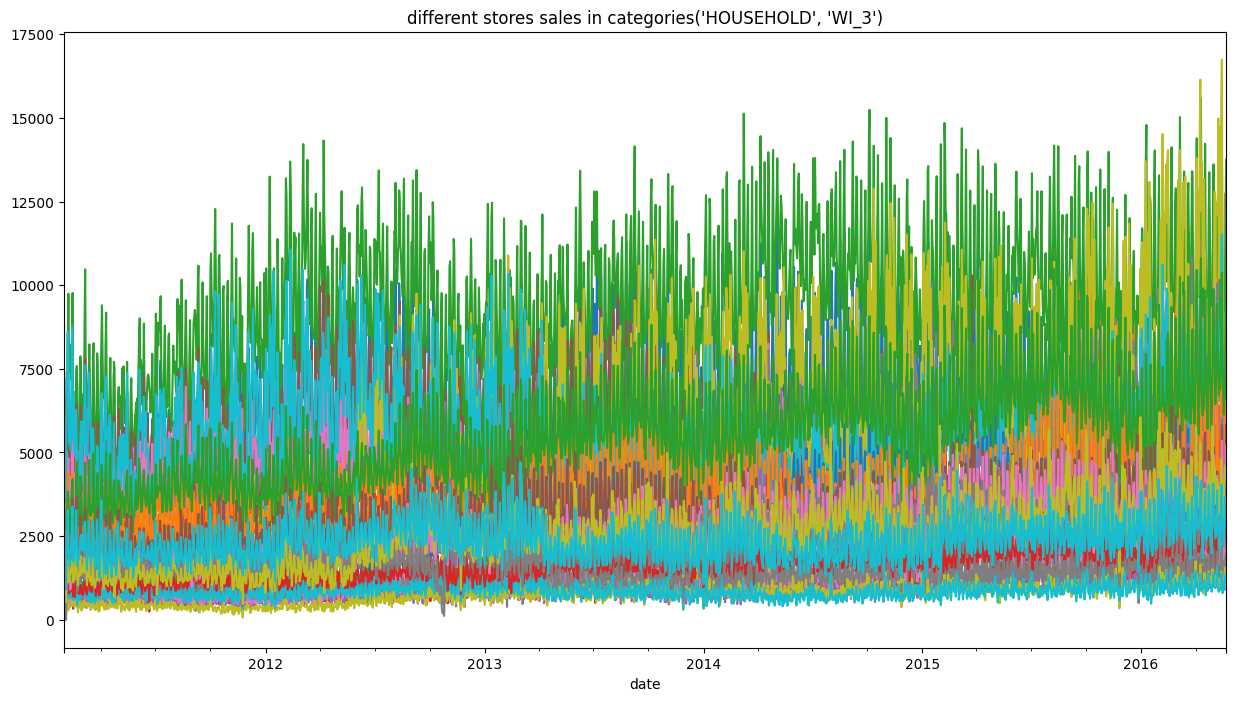

In [37]:
for col in list(df_pivot.columns):
   df_pivot[col].plot(kind='line',title='different stores sales in categories'+str(col),figsize=(15,8))

In [38]:
sp_df_copy.loc[sp_df_copy.cat_id=='FOODS']

,store_id,cat_id,date,sales
0,TX_1,FOODS,2011-01-29,3950.35
1,TX_1,FOODS,2011-01-30,3844.97
2,TX_1,FOODS,2011-01-31,2888.03
3,TX_1,FOODS,2011-02-01,3631.28
4,TX_1,FOODS,2011-02-02,3072.18
...,...,...,...,...
54343,WI_3,FOODS,2016-05-18,5808.82
54344,WI_3,FOODS,2016-05-19,6246.16
54345,WI_3,FOODS,2016-05-20,7072.82
54346,WI_3,FOODS,2016-05-21,7557.70


In [45]:
pd.pivot_table(sp_df_copy.loc[sp_df_copy.cat_id=='FOODS'],index='date',columns=['store_id','cat_id'],values='sales')




store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
cat_id,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
date,,,,,,,,,,
2011-01-29,7240.65,4712.14,7191.08,2875.69,3950.35,5877.90,4681.27,2954.50,2904.92,5661.00
2011-01-30,6705.51,4173.56,7395.35,3023.22,3844.97,5731.30,4625.89,2478.36,2483.22,6005.69
2011-01-31,4584.85,2630.87,5531.81,2249.67,2888.03,3992.68,3493.71,1776.23,2862.85,4924.04
2011-02-01,4965.46,2725.75,6259.16,2321.78,3631.28,4533.96,3705.31,1602.99,3682.44,4956.70
2011-02-02,4368.07,2719.78,5639.18,2617.96,3072.18,3744.43,2925.76,2.96,1944.96,3519.63
...,...,...,...,...,...,...,...,...,...,...
2016-05-18,7566.39,7178.31,9186.87,4600.58,5146.18,5926.65,6513.29,5994.16,8409.44,5808.82
2016-05-19,7480.58,7556.12,9556.69,4558.91,4647.91,5840.58,6275.03,6374.03,8173.70,6246.16


In [49]:
sdf=pd.pivot_table(sp_df_copy.loc[sp_df_copy.cat_id=='FOODS'],index='date',columns=['cat_id','store_id'],values='sales')

sdf.columns.values

array([('FOODS', 'CA_1'), ('FOODS', 'CA_2'), ('FOODS', 'CA_3'),
       ('FOODS', 'CA_4'), ('FOODS', 'TX_1'), ('FOODS', 'TX_2'),
       ('FOODS', 'TX_3'), ('FOODS', 'WI_1'), ('FOODS', 'WI_2'),
       ('FOODS', 'WI_3')], dtype=object)

In [50]:
sdf.columns = [' '.join(col).strip() for col in sdf.columns.values]
sdf.columns

Index(['FOODS CA_1', 'FOODS CA_2', 'FOODS CA_3', 'FOODS CA_4', 'FOODS TX_1',
       'FOODS TX_2', 'FOODS TX_3', 'FOODS WI_1', 'FOODS WI_2', 'FOODS WI_3'],
      dtype='object')

In [51]:
sdf

,FOODS CA_1,FOODS CA_2,FOODS CA_3,FOODS CA_4,FOODS TX_1,FOODS TX_2,FOODS TX_3,FOODS WI_1,FOODS WI_2,FOODS WI_3
date,,,,,,,,,,
2011-01-29,7240.65,4712.14,7191.08,2875.69,3950.35,5877.90,4681.27,2954.50,2904.92,5661.00
2011-01-30,6705.51,4173.56,7395.35,3023.22,3844.97,5731.30,4625.89,2478.36,2483.22,6005.69
2011-01-31,4584.85,2630.87,5531.81,2249.67,2888.03,3992.68,3493.71,1776.23,2862.85,4924.04
2011-02-01,4965.46,2725.75,6259.16,2321.78,3631.28,4533.96,3705.31,1602.99,3682.44,4956.70
2011-02-02,4368.07,2719.78,5639.18,2617.96,3072.18,3744.43,2925.76,2.96,1944.96,3519.63
...,...,...,...,...,...,...,...,...,...,...
2016-05-18,7566.39,7178.31,9186.87,4600.58,5146.18,5926.65,6513.29,5994.16,8409.44,5808.82
2016-05-19,7480.58,7556.12,9556.69,4558.91,4647.91,5840.58,6275.03,6374.03,8173.70,6246.16
2016-05-20,7846.33,8806.22,9221.94,4734.90,5977.50,6963.98,7326.73,6890.79,8441.53,7072.82
